In [1]:
this_notebook_name = "SagittalSpineSegmentationTest"

# Update this folder name for your computer

train_timestamp = "2020-01-26_15-16-58"
local_data_folder = r"d:\Data\SagittalSpineSegmentationStudy"

overwrite_existing_data_files = False

# All results and output will be archived with this timestamp

# Evaluation parameters

acceptable_margin_mm = 1.0
mm_per_pixel = 1.0

roc_thresholds = [0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1,
                  0.08, 0.06, 0.04, 0.02, 0.01,
                  0.008, 0.006, 0.004, 0.002, 0.001]

limit_rounds = 0

# Uncomment for faster debugging
roc_thresholds = [0.8, 0.6, 0.4, 0.2, 0.1, 0.01]
limit_rounds = 2

In [15]:
import glob
import os
import sys
import datetime
from random import sample

from ipywidgets import IntProgress
from IPython.display import display, HTML

import girder_client
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf

# import ultrasound_batch_generator as generator
# import sagittal_spine_segmentation_unet as unet
import evaluation_metrics

In [6]:
testing_ultrasound_filename = "ultrasound-test.npy"
testing_ultrasound_id = "5daa85edd9e6a3be02d012e7"
testing_segmentation_filename = "segmentation-test.npy"
testing_segmentation_id = "5daa85e7d9e6a3be02d012e4"

# Default subfolders of main project data folder

data_arrays_folder      = "DataArrays"
notebooks_save_folder   = "SavedNotebooks"
models_folder           = "SavedModels"
results_save_folder     = "SavedResults"
test_predictions_folder = "PredictionsTest"

data_arrays_fullpath      = os.path.join(local_data_folder, data_arrays_folder)
notebooks_save_fullpath   = os.path.join(local_data_folder, notebooks_save_folder)
models_fullpath           = os.path.join(local_data_folder, models_folder)
results_save_fullpath     = os.path.join(local_data_folder, results_save_folder)
test_predictions_fullpath = os.path.join(local_data_folder, test_predictions_folder)

if not os.path.exists(data_arrays_fullpath):
    os.makedirs(data_arrays_fullpath)
    print("Created folder: {}".format(data_arrays_fullpath))

if not os.path.exists(notebooks_save_fullpath):
    os.makedirs(notebooks_save_fullpath)
    print("Created folder: {}".format(notebooks_save_fullpath))

if not os.path.exists(models_fullpath):
    raise FileNotFoundError(models_fullpath)

if not os.path.exists(results_save_fullpath):
    os.makedirs(results_save_fullpath)
    print("Created folder: {}".format(results_save_fullpath))

if not os.path.exists(test_predictions_fullpath):
    os.makedirs(test_predictions_fullpath)
    print("Created folder: {}".format(test_predictions_fullpath))

In [29]:
# Download data from Girder

girder_url = "https://pocus.cs.queensu.ca/api/v1"
girder_key = None

time_download_start = datetime.datetime.now()

gclient = girder_client.GirderClient(apiUrl=girder_url)
if girder_key is not None:
    gclient.authenticate(apiKey=girder_key)

print("Downloading training files ...")

test_ultrasound_fullname = os.path.join(data_arrays_fullpath, testing_ultrasound_filename)
if not os.path.exists(test_ultrasound_fullname):
    print("Downloading {}...".format(test_ultrasound_fullname))
    gclient.downloadFile(testing_ultrasound_id, test_ultrasound_fullname)

test_segmentation_fullname = os.path.join(data_arrays_fullpath, testing_segmentation_filename)
if not os.path.exists(test_segmentation_fullname) or overwrite_existing_data_files:
    print("Downloading {}...".format(test_segmentation_fullname))
    gclient.downloadFile(testing_segmentation_id, test_segmentation_fullname)
    
time_download_stop = datetime.datetime.now()
print("\nTotal download time: {}".format(time_download_stop - time_download_start))


Total download time: 0:00:09.380326


In [8]:
# Read data into numpy arrays

time_start = datetime.datetime.now()

test_ultrasound_fullname = os.path.join(data_arrays_fullpath, testing_ultrasound_filename)
test_ultrasound_array = np.load(test_ultrasound_fullname)

test_segmentation_fullname = os.path.join(data_arrays_fullpath, testing_segmentation_filename)
test_segmentation_array = np.load(test_segmentation_fullname)
    
time_stop = datetime.datetime.now()
print("\nTotal time to load from files: {}".format(time_stop - time_start))


Total time to load from files: 0:00:00.244346


In [9]:
filename_pattern = "*" + train_timestamp + "*"
search_string = os.path.join(models_fullpath, filename_pattern)
print("Searching for models by {}".format(search_string))
model_file_list = glob.glob(search_string)

num_models = len(model_file_list)
print("Found {} models".format(num_models))

if limit_rounds > 0:
    num_rounds = min(num_models, limit_rounds)
else:
    num_rounds = num_models

Searching for models by d:\Data\SagittalSpineSegmentationStudy\SavedModels\*2020-01-26_15-16-58*
Found 1 models


In [19]:
# Import aigt modules

parent_folder = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(parent_folder)

import Models.segmentation_unet as unet
wcce = unet.weighted_categorical_crossentropy([0.05, 0.95])

In [20]:
# Main loop, test all models and save test results

time_sequence_start = datetime.datetime.now()

print("Using timestemp to find files: {}".format(train_timestamp))
print("Saving test predictions in:    {}".format(test_predictions_fullpath))

test_best_metrics    = dict()
test_fuzzy_metrics   = dict()
test_aurocs          = np.zeros(num_models)
test_best_thresholds = np.zeros(num_models)

for i in range(num_models):
    time_round_start = datetime.datetime.now()
    
    print("Testing model: {}".format(model_file_list[i]))
    model = tf.keras.models.load_model(model_file_list[i], custom_objects={'loss': wcce})
    test_prediction = model.predict(test_ultrasound_array)
    
    test_prediction_filename = train_timestamp + "_prediction_test.npy"
    test_prediction_fullname = os.path.join(test_predictions_fullpath, test_prediction_filename)
    np.save(test_prediction_fullname, test_prediction)
    
    # Test results
    
    test_metrics_dicts, test_best_threshold_index, test_area = evaluation_metrics.compute_roc(
        roc_thresholds, test_prediction, test_segmentation_array, acceptable_margin_mm, mm_per_pixel)
    
    test_fuzzy_metrics[i] = evaluation_metrics.compute_evaluation_metrics(
        test_prediction, test_segmentation_array, acceptable_margin_mm, mm_per_pixel)
    
    test_best_metrics[i]    = test_metrics_dicts[test_best_threshold_index]
    test_aurocs[i]          = test_area
    test_best_thresholds[i] = roc_thresholds[test_best_threshold_index]
    
    print("Testing round time: {}".format(datetime.datetime.now() - time_round_start))


time_sequence_stop = datetime.datetime.now()

print("\nTotal testing time:   {}".format(time_sequence_stop - time_sequence_start))

Using timestemp to find files: 2020-01-26_15-16-58
Saving test predictions in:    d:\Data\SagittalSpineSegmentationStudy\PredictionsTest
Testing model: d:\Data\SagittalSpineSegmentationStudy\SavedModels\SagittalSpineSegmentationStudy-TF2_model-4_2020-01-26_15-16-58.h5
Testing round time: 0:00:19.066037

Total testing time:   0:00:19.067034


In [21]:
# Arrange results in tables

metric_labels = [
    "AUROC",
    "best thresh",
    "best TP",
    "best FP",
    "best recall",
    "best precis",
    "fuzzy recall",
    "fuzzy precis",
    "fuzzy Fscore"
]

results_labels = []

for label in metric_labels:
    results_labels.append("Test " + label)

    
results_df = pd.DataFrame(columns = results_labels)

for i in range(num_rounds):
    results_df.loc[i] = [
        test_aurocs[i],
        test_best_thresholds[i],
        test_best_metrics[i][evaluation_metrics.TRUE_POSITIVE_RATE],
        test_best_metrics[i][evaluation_metrics.FALSE_POSITIVE_RATE],
        test_best_metrics[i][evaluation_metrics.RECALL],
        test_best_metrics[i][evaluation_metrics.PRECISION],
        test_fuzzy_metrics[i][evaluation_metrics.RECALL],
        test_fuzzy_metrics[i][evaluation_metrics.PRECISION],
        test_fuzzy_metrics[i][evaluation_metrics.FSCORE],
    ]

display(results_df)

print("\nAverages")

results_means_df = results_df.mean()
display(results_means_df)

,Test AUROC,Test best thresh,Test best TP,Test best FP,Test best recall,Test best precis,Test fuzzy recall,Test fuzzy precis,Test fuzzy Fscore
0,0.953071,0.01,0.957795,0.032372,0.957795,0.076002,0.664925,0.246828,0.360014



Averages


Test AUROC           0.953071
Test best thresh     0.010000
Test best TP         0.957795
Test best FP         0.032372
Test best recall     0.957795
Test best precis     0.076002
Test fuzzy recall    0.664925
Test fuzzy precis    0.246828
Test fuzzy Fscore    0.360014
dtype: float64

In [22]:
# Save results table

csv_filename = this_notebook_name + "_" + train_timestamp + ".csv"
csv_fullname = os.path.join(results_save_fullpath, csv_filename)
results_df.to_csv(csv_fullname)

print("Results saved to: {}".format(csv_fullname))

Results saved to: d:\Data\SagittalSpineSegmentationStudy\SavedResults\SagittalSpineSegmentationTest_2020-01-26_15-16-58.csv


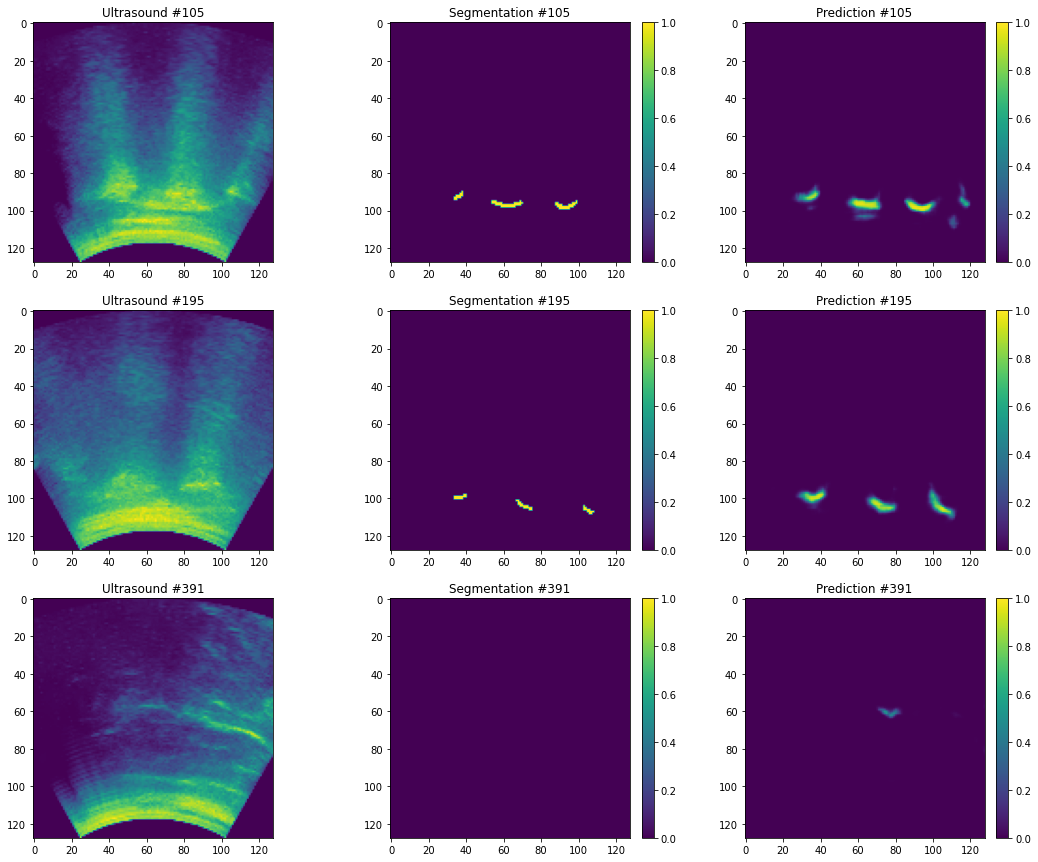

In [23]:
# Display sample results

num_test = test_ultrasound_array.shape[0]
num_show = 3

indices = [i for i in range(num_test)]
sample_indices = sample(indices, num_show)
sample_indices = [105, 195, 391]

fig = plt.figure(figsize=(18, num_show*5))
for i in range(num_show):
    a0 = fig.add_subplot(num_show,3,i*3+1)
    img0 = a0.imshow(test_ultrasound_array[sample_indices[i], :, :, 0].astype(np.float32))
    a0.set_title("Ultrasound #{}".format(sample_indices[i]))
    a1 = fig.add_subplot(num_show,3,i*3+2)
    img1 = a1.imshow(test_segmentation_array[sample_indices[i], :, :, 0], vmin=0.0, vmax=1.0)
    a1.set_title("Segmentation #{}".format(sample_indices[i]))
    c = fig.colorbar(img1, fraction=0.046, pad=0.04)
    a2 = fig.add_subplot(num_show,3,i*3+3)
    img2 = a2.imshow(test_prediction[sample_indices[i], :, :, 1], vmin=0.0, vmax=1.0)
    a2.set_title("Prediction #{}".format(sample_indices[i]))
    c = fig.colorbar(img2, fraction=0.046, pad=0.04)

In [24]:
# Save notebook so all output is archived by the next cell

from IPython.display import Javascript
script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
Javascript(script)

<IPython.core.display.Javascript object>

In [26]:
# Export HTML copy of this notebook

notebook_file_name = this_notebook_name + "_" + train_timestamp + ".html"
notebook_fullname = os.path.join(notebooks_save_fullpath, notebook_file_name)

os.system("jupyter nbconvert --to html " + this_notebook_name + " --output " + notebook_fullname)
print("Notebook saved to: {}".format(notebook_fullname))

Notebook saved to: d:\Data\SagittalSpineSegmentationStudy\SavedNotebooks\SagittalSpineSegmentationTest_2020-01-26_15-16-58.html
